# Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_experimental_data(n_points=10,M0=300,V0=100,rho=1,V_min=110,V_max=200,err_M=0.025,err_V=0.10,noise=5):
    # Generate volume values evenly spaced between V_min and V_max.
    V_values = np.linspace(V_min, V_max, n_points)
    # Calculate the mass values from the linear relation plus noise.
    M_values = rho * V_values + (M0 - rho * V0) + np.random.uniform(-noise, noise, n_points)
    # Create the DataFrame including the measurement uncertainties.
    df = pd.DataFrame({
        'M': M_values,
        'sigma_M': M_values * err_M,
        'V': V_values,
        'sigma_V': V_values * err_V     
    })
    return df

def calculate_fit(df, M0=300, V0=100, rho=1):
    # Extract the independent (x) and dependent (y) values.
    V_values = df['V'].values
    M_values = df['M'].values
    N = len(V_values)
    # Calculate necessary summations.
    sum_x = np.sum(V_values)
    sum_y = np.sum(M_values)
    sum_x2 = np.sum(V_values ** 2)
    sum_xy = np.sum(V_values * M_values)
    # Denominator for the slope and intercept formulas.
    D = N * sum_x2 - sum_x ** 2
    # Calculate slope (a) and intercept (b).
    a = (N * sum_xy - sum_x * sum_y) / D
    # 
    b = (sum_y - a * sum_x) / N
    # Predicted Mass values using the regression line.
    y_pred = a * V_values + b
    # Residual standard error.
    sigma_y = np.sqrt(np.sum((M_values - y_pred) ** 2) / (N - 2))
    # Compute Sxx for calculating uncertainties.
    Sxx = sum_x2 - (sum_x ** 2) / N
    #
    sigma_a = sigma_y / np.sqrt(Sxx)
    # Standard error for the intercept.
    x_bar = sum_x / N
    #
    sigma_b = sigma_y * np.sqrt(1 / N + (x_bar ** 2) / Sxx)
    #
    fit_params = {
        'M0': M0,
        'V0': V0,
        'rho': rho,
        'a': a,
        'sigma_a': sigma_a,
        'b': b,
        'sigma_b': sigma_b,
        'y_pred': y_pred,
        'sigma_y': sigma_y,
    }
    tb = pd.DataFrame([fit_params])
    return tb, fit_params
    

def plot_regression(df, fit_results):
    # Extract data from the DataFrame.
    V_values = df['V'].values
    M_values = df['M'].values
    # Check if the DataFrame contains error columns.
    V_err = df['sigma_V'].values if 'sigma_V' in df.columns else None
    M_err = df['sigma_M'].values if 'sigma_M' in df.columns else None
    # Extract the regression fit results.
    y_pred = fit_results['y_pred']
    a = fit_results['a']
    b = fit_results['b']
    sigma_a = fit_results['sigma_a']
    sigma_b = fit_results['sigma_b']
    # Sort the Volume values and corresponding predictions for a smooth line.
    sort_idx = np.argsort(V_values)
    V_sorted = V_values[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    # Compute the uncertainty in the predicted y-values using error propagation:
    # σ_y = sqrt((x * σ_a)² + σ_b²)
    uncertainty = np.sqrt((V_sorted * sigma_a)**2 + sigma_b**2)
    y_upper = y_pred_sorted + uncertainty
    y_lower = y_pred_sorted - uncertainty
    # define image
    plt.figure(figsize=(8, 5))
    # Plot experimental data with error bars if uncertainties are provided.
    if V_err is not None or M_err is not None:
        plt.errorbar(V_values, M_values, xerr=V_err, yerr=M_err,
                     fmt='o', color='black', capsize=2, label="Experimental Data")
    else:
        plt.scatter(V_values, M_values, color='r', label="Experimental Data")
    # Plot the best-fit regression line.
    plt.plot(V_sorted, y_pred_sorted, linestyle='--', color='b',
             label=f"Best Fit: y = ({a:.4f} ± {sigma_a:.4f})x + ({b:.2f} ± {sigma_b:.2f})")
    # Add the uncertainty band around the regression line.
    plt.fill_between(V_sorted, y_lower, y_upper, color='blue', alpha=0.2,
                     label='Uncertainty Band')
    plt.xlabel("Volume (mL)")
    plt.ylabel("Mass (g)")
    plt.title("Least Squares Regression: Mass vs. Volume")
    plt.grid(True)
    plt.legend()
    plt.show()

    
def format_table(df):
    return pd.DataFrame({
        "$(M_i \\pm \\delta M_i) \\ g$": [f"{M:.3f} ± {sigma_M:.3f}" for M, sigma_M in zip(df["M"], df["sigma_M"])],
        "$\\frac{\\delta M_i}{M_i}$": [f"{(sigma_M / M):.3f}" for M, sigma_M in zip(df["M"], df["sigma_M"])],
        "$(V_i \\pm \\delta V_i) \\ ml$": [f"{V:.3f} ± {sigma_V:.3f}" for V, sigma_V in zip(df["V"], df["sigma_V"])],
        "$\\frac{\\delta V_i}{V_i}$": [f"{(sigma_V / V):.3f}" for V, sigma_V in zip(df["V"], df["sigma_V"])]
    })

# Analysis

In [2]:
# 1. Generate the experimental data (with measurement uncertainties).
df = generate_experimental_data(n_points=10,M0=200,V0=100,rho=1,V_min=110,V_max=200,err_M=0.02,err_V=0.02,noise=2)

# 2. Calculate the linear fit parameters.
tb1, fit_params = calculate_fit(df, M0=300, V0=100, rho=1)

# Creates a formated table for the experiment
tb2 = format_table(df)

# Artifacts

## Auxiliary dataframe

In [3]:
df

,M,sigma_M,V,sigma_V
0,210.805319,4.216106,110.0,2.2
1,220.690695,4.413814,120.0,2.4
2,230.308746,4.606175,130.0,2.6
3,238.193217,4.763864,140.0,2.8
4,249.039235,4.980785,150.0,3.0
5,258.531909,5.170638,160.0,3.2
6,271.597020,5.431940,170.0,3.4
7,278.592510,5.571850,180.0,3.6
8,288.063108,5.761262,190.0,3.8
9,300.783389,6.015668,200.0,4.0


## Table with experimental results

In [4]:
tb2

,$(M_i \pm \delta M_i) \ g$,$\frac{\delta M_i}{M_i}$,$(V_i \pm \delta V_i) \ ml$,$\frac{\delta V_i}{V_i}$
0,210.805 ± 4.216,0.020,110.000 ± 2.200,0.020
1,220.691 ± 4.414,0.020,120.000 ± 2.400,0.020
2,230.309 ± 4.606,0.020,130.000 ± 2.600,0.020
3,238.193 ± 4.764,0.020,140.000 ± 2.800,0.020
4,249.039 ± 4.981,0.020,150.000 ± 3.000,0.020
5,258.532 ± 5.171,0.020,160.000 ± 3.200,0.020
6,271.597 ± 5.432,0.020,170.000 ± 3.400,0.020
7,278.593 ± 5.572,0.020,180.000 ± 3.600,0.020
8,288.063 ± 5.761,0.020,190.000 ± 3.800,0.020
9,300.783 ± 6.016,0.020,200.000 ± 4.000,0.020


## Plot of the linear model for M vs V

In [5]:
df

,M,sigma_M,V,sigma_V
0,210.805319,4.216106,110.0,2.2
1,220.690695,4.413814,120.0,2.4
2,230.308746,4.606175,130.0,2.6
3,238.193217,4.763864,140.0,2.8
4,249.039235,4.980785,150.0,3.0
5,258.531909,5.170638,160.0,3.2
6,271.597020,5.431940,170.0,3.4
7,278.592510,5.571850,180.0,3.6
8,288.063108,5.761262,190.0,3.8
9,300.783389,6.015668,200.0,4.0


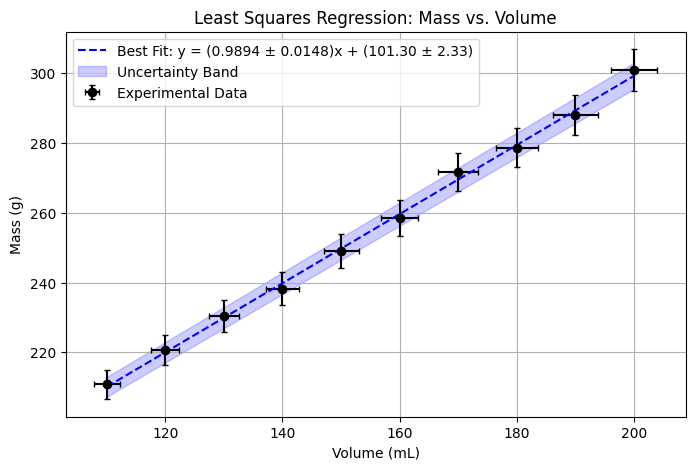

In [6]:
# 3. Plot the experimental data with the regression line.
plot_regression(df, fit_params)

# References

* https://laboratoriodefisicaufla.blogspot.com/2013/10/metodo-dos-minimos-quadrados_12.html
* https://medium.com/analytics-vidhya/expectation-variance-of-ols-estimates-9acd2b48a635
* http://fisexp2.if.ufrj.br/Fisexp2_Apostila2024.pdf
* http://fisexp2.if.ufrj.br/Relatorios/Relatorio_1.pdf